## Práctica 4b: selección de características categóricas.
**Nota:** Antes de implementar los siguientes métodos, debemos asegurarnos de que el DataFrame sólo contiene características categóricas.

### Preparación del conjunto de datos: Temperature 
En el conjunto de datos se encuentran datos de la temperatura del ambiente durante un determinado tiempo.

Un modelo trivial puede lograr una precisión del (70%) en este conjunto de datos. Un buen puntaje es de aproximadamente (76% +/- 3%).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
low_memory = False
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [3]:
file = "pmsm_temperature_data.csv"
df = pd.read_csv(file)
def to_category(a):
    bins=np.linspace(min(df[a]),max(df[a]),4)
    names=["a","b","c"]
    df[a]=pd.cut(df[a],bins,labels=names)
to_category("ambient")
to_category("coolant")
to_category("u_d")
to_category("u_q")
to_category("motor_speed")
to_category("torque")
to_category("i_d")
to_category("i_q")
to_category("stator_yoke")
to_category("stator_tooth")
to_category("stator_winding")
bins=np.linspace(min(df["pm"]),max(df["pm"]),4)
names=["Normal","Alta","Sobrecalentamiento"]
df["pm"]=pd.cut(df["pm"],bins,labels=names)
df = df.dropna()
X = df.drop("pm",1)
y = df["pm"]
df = pd.concat([X, y], axis = 1)
df.to_csv("Archivo.csv", header = True, index = False)

In [5]:
file = "Archivo.csv"
data = pd.read_csv(file, header=None)
# arreglo
dataset = data.values

Una vez cargado el conjunto de datos, podemos dividirlo en datos de entrada o características (X) y salida variable de salida o target (y).

In [6]:
x = dataset[:, :-1]
y = dataset[:, -1]

Podemos forzar que todos los campos de los datos de entrada sean string, por si acaso Pandas malinterpretara alguna variable.

In [7]:
X = X.astype(str)

Podremos juntar este proceso en una función que podemos reutilizar más tarde.

In [8]:
def load_dataset(filename):
    # Cargamos el Dataframe
    data = pd.read_csv(filename, header=None)
    # Generamos un arreglo
    dataset = data.values
    # Dividimos en X y y
    X = dataset[:, :-1]
    y = dataset[:,-1]
    # Forzamos que X sea string 
    X = X.astype(str)
    return X, y

Una vez cargados los datos, podemos dividirlos en conjuntos de entrenamiento (train) y pruebas (test) para que podamos encontar y evaluar un modelo de aprendizaje. Utilizaremos la función train_test_split() de scikit-learn y utilizaremos el 67% de los datos para el entrenamiento y el 33% para las pruebas.

In [9]:
# Cargamos el dataset
X, y = load_dataset(file)

# Dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Checamos las dimensiones
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

C:\Users\perez\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Train (668700, 12) (668700,)
Test (329361, 12) (329361,)


Podemos usar el OrdinalEncoder() de scikit-learn para codificar cada variable categórica a números enteros. Esta es una clase flexible y permite especificar el orden de las categorías como argumentos si se conoce dicho orden.

In [10]:
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    oe.fit(X_test)
    X_test_enc =  oe.transform(X_test)
    return X_train_enc, X_test_enc
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)

También necesitamos preparar la variable target. Este un problema de clasificación binaria, por lo que necesitamos convertir las dos etiquetas categóricas a binarias, 0 y 1, este es un tipo de codificación ordinal. Scikit-learn proporciona la clase LabelEncoder diseñada específicamente para este propósito. Podríamos usar el OrdinalEncoder y obtener el mismo resultado, aunque el LabelEncoder está diseñado para codificar una sola variable.

La función prepare_targets() codifica los datos de salida para el train y test.

In [11]:
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    le.fit(y_test)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

# Preparamos los datos de entrada o características
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)

# Preparamos los datos de salida o target
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

### Chi-Squared
La prueba de hipótesis estadística chi-cuadrado de Pearson (Chi-squared) es un ejemplo de una prueba de independencia entre variables categóricas. Los resultados de esta prueba se pueden utilizar para la selección de características, donde aquellas características que son independientes de la variable objetivo se pueden eliminar del conjunto de datos.

La función chi2() puede utilizarse para la selección de las características más relevantes de k (valores más grandes) a través de la clase SelectKBest. Por ejemplo, podemos definir la clase SelectKBest para utilizar la función chi2() y seleccionar todas las características.

In [12]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [13]:
# Selección de características con chi-squared
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)

Característica 0: 7648.110230
Característica 1: 89413.373621
Característica 2: 3863.849927
Característica 3: 4065.386456
Característica 4: 50595.477388
Característica 5: 878.862739
Característica 6: 9784.299007
Característica 7: 1090.625757
Característica 8: 143694.675584
Característica 9: 141876.487902
Característica 10: 124388.571040
Característica 11: 461082.337568


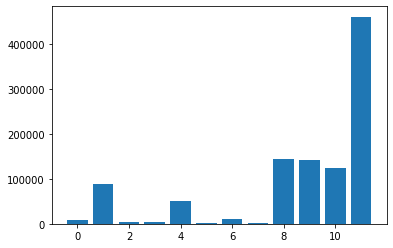

In [14]:
for i in range(len(fs.scores_)):
    print('Característica %d: %f' % (i, fs.scores_[i]))

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

### Selección de características de información mutua (Mutual Information)
La información mutua del campo de la teoría de la información es la aplicación de la ganancia de información (típicamente usada en la construcción de árboles de decisión) a la selección de características. La información mutua se calcula entre dos variables y mide la reducción de la incertidumbre de una variable dado un valor conocido de la otra variable.

Al igual que chi2(), puede utilizarse en la estrategia de selección de características de SelectKBest (y otras estrategias).

In [15]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [16]:
# Selección de características con mutual information
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)

Característica 0: 0.129308
Característica 1: 0.114201
Característica 2: 0.049437
Característica 3: 0.030795
Característica 4: 0.063946
Característica 5: 0.044826
Característica 6: 0.077333
Característica 7: 0.045114
Característica 8: 0.233886
Característica 9: 0.294247
Característica 10: 0.254057
Característica 11: 0.241455


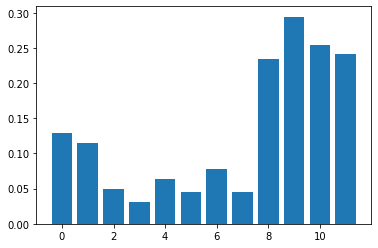

In [17]:
for i in range(len(fs.scores_)):
    print('Característica %d: %f' % (i, fs.scores_[i]))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()